# 0.0 Imports

In [56]:
import inflection
import io
import math
import time
import random
import numpy as np
import pandas as pd
import seaborn as snb
import time
import sweetviz as sv
import warnings

from xgboost import XGBClassifier
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import tree
from boruta import BorutaPy
from sklearn.preprocessing import RobustScaler
from category_encoders import CountEncoder, TargetEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder 
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import datetime
from sklearn.naive_bayes import BernoulliNB



%matplotlib inline
snb.set_style('whitegrid')
warnings.filterwarnings('ignore')


## Functions

In [3]:
def show_dtypes(df):
    print(df.dtypes)
    return None

def show_dimensions(df):
    print('Number of rows: {}' .format(df.shape[0]))
    print('Number of columns: {}' .format(df.shape[1]))
    return None

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return round(np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) ),2)

# 1.0 Loading Data

In [19]:
df_train = pd.read_csv('dataset/train.csv')
df_test  = pd.read_csv('dataset/test.csv')
sub_m = pd.read_csv('dataset/submission.csv')

## Rename columns

In [20]:
df = df_train.copy()

In [21]:
df = df.rename(columns={'Classificação do hotel': 'hotel_rating', 'Meses da reserva até o check-in': 'month_booking',
                        'Número de pernoites reservadas': 'number_stays_booking', 'Número de hospedes': 'number_guests',
                        'Regime de alimentação': 'meal_regime', 'Nacionalidade': 'nationality', 'Forma de Reserva': 'reservation_Form',
                        'Já se hospedou anterioremente': 'previously_hosted', 'Tipo do quarto reservado': 'type_booked_room',
                        'Reserva feita por agência de turismo': 'tourism_agency_booking', 'Reserva feita por empresa': 'company_booking',
                        'Reserva com Estacionamento': 'parking_Reservation', 'Reserva com Observações': 'reservation_Observations', 'Reserva Cancelada': 'booking_canceled'})


### Fill drop Na

In [22]:
df.dropna(inplace=True)
#df['nationality'] = df['nationality'].apply(
#    lambda x: 'nao_identificado' if pd.isnull(x) else x)



In [23]:
df.isna().sum()

id                          0
hotel_rating                0
month_booking               0
number_stays_booking        0
number_guests               0
meal_regime                 0
nationality                 0
reservation_Form            0
previously_hosted           0
type_booked_room            0
tourism_agency_booking      0
company_booking             0
parking_Reservation         0
reservation_Observations    0
booking_canceled            0
dtype: int64

In [24]:
# Verificar valores duplicados
df.duplicated().sum()

0

### Change Type

In [25]:
df['id'] = df['id'].astype('int64')



### Data Praration

In [26]:
df2 = df.copy()

### Rescaling

In [27]:
rs = RobustScaler()

# meses_da_reserva_ate_o_check-in - Robust Scaler
df2['id'] = rs.fit_transform( df2[['id']].values )

# meses_da_reserva_ate_o_check-in - Robust Scaler
df2['month_booking'] = rs.fit_transform(df2[['month_booking']].values)

# numero_de_pernoites_reservadas - Robust Scaler
df2['number_stays_booking'] = rs.fit_transform( df2[['number_stays_booking']].values)

# numero_de_hospedes - Robust Scaler
df2['number_guests'] = rs.fit_transform( df2[['number_guests']].values)

### Transformacao

In [28]:
df3 = df2.copy()

In [181]:
# # classificacao_do_hotel
# df4['hotel_rating'] = df4['hotel_rating'].apply(lambda x: int(x.split('estrela')[1]))

# # ja_se_hospedou_anterioremente
# df4['previously_hosted'] = df4['previously_hosted'].apply(
#     lambda x: x.replace('Sim', '1'))
# df4['previously_hosted'] = df4['previously_hosted'].apply(
#     lambda x: x.replace('Não', '0'))

# # reserva_feita_por_agencia_de_turismo
# df4['tourism_agency_booking'] = df4['tourism_agency_booking'].apply(
#     lambda x: x.replace('Sim', '1'))
# df4['tourism_agency_booking'] = df4['tourism_agency_booking'].apply(
#     lambda x: x.replace('Não', '0'))

# # reserva_com_estacionamento
# df4['parking_Reservation'] = df4['parking_Reservation'].apply(
#     lambda x: x.replace('Sim', '1'))
# df4['parking_Reservation'] = df4['parking_Reservation'].apply(
#     lambda x: x.replace('Não', '0'))

# # reserva_feita_por_empresa
# df4['company_booking'] = df4['company_booking'].apply(
#     lambda x: x.replace('Sim', '1'))
# df4['company_booking'] = df4['company_booking'].apply(
#     lambda x: x.replace('Não', '0'))


In [182]:
df3['meal_regime'].unique()


array(['Café da manha e jantar', 'Café da manha', 'Sem refeicao',
       'Café da manha, almoco e jantar'], dtype=object)

In [30]:
# Label Encoder
le = LabelEncoder()
label_cols = ['meal_regime', 'nationality', 'reservation_Form', 'type_booked_room', 'reservation_Observations']
for col in label_cols:
    df3[col] = le.fit_transform(df3[col])

# Ordinal Encoding
classificacao_dict = {'5 estrelas': 5, '4 estrelas': 4}
df3['hotel_rating'] = df3['hotel_rating'].map(classificacao_dict)

# Boolean
bool_cols = ['previously_hosted','tourism_agency_booking','company_booking','parking_Reservation']
for col in bool_cols:
    df3[col] = df3[col].apply(
        lambda x: 0 if x == 'Não' else 1 if x == 'Sim' else x)


In [31]:

# transform into int
df3['hotel_rating'] = df3['hotel_rating'].astype('int')
df3['previously_hosted'] = df3['previously_hosted'].astype('int')
df3['tourism_agency_booking'] = df3['tourism_agency_booking'].astype('int')
df3['company_booking'] = df3['company_booking'].astype('int')
df3['parking_Reservation'] = df3['parking_Reservation'].astype('int')


# Feature Selection

In [32]:
# Split Train Test Dataset
df5 = df3.copy()
X = df5.drop(columns=['booking_canceled'])
y = df5[['booking_canceled']]


In [38]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)


In [39]:
len(X_train)

56850

In [40]:
# criar objeto RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# realizar o upsampling na base de treino
X_train, y_train = oversampler.fit_resample( X_train, y_train )

In [45]:
y_train

,booking_canceled
0,1
1,1
2,0
3,1
4,1
...,...
71127,1
71128,1
71129,1
71130,1


In [48]:
y_train['booking_canceled'].value_counts()

1    35566
0    35566
Name: booking_canceled, dtype: int64

### Boruta as Feature Selector

In [49]:
#define RandomForestRegressor
clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)

# define Boruta
boruta = BorutaPy(clf, n_estimators='auto',verbose=2,random_state=0).fit(X_train.values, y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	7
Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	7
Iteration: 	10 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	7
Iteration: 	11 / 100
Confirmed: 	6
Tentative: 	1
Rejected: 	7
Iteration: 	12 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	8


BorutaPy finished running.

Iteration: 	13 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	8


## Best Features from Boruta

In [50]:
cols_selected_boruta = boruta.support_.tolist()
cols_selected_boruta = X_train.iloc[:,cols_selected_boruta].columns.tolist()

## Best Features from Random Forest

In [51]:
clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
model = clf.fit(X_train.values, y_train.values)

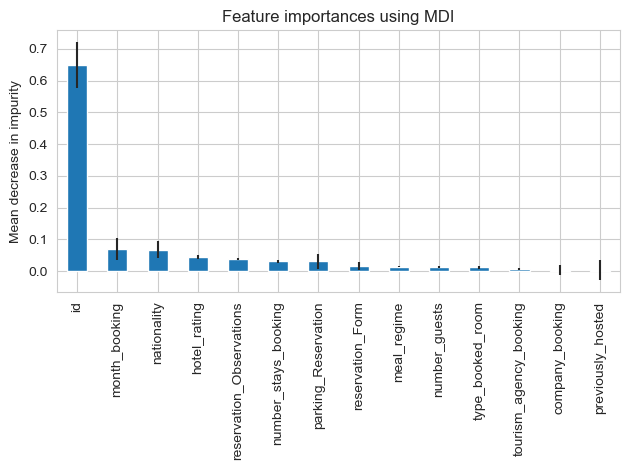

In [53]:
import time
import numpy as np
import pandas as pd

importances = model.feature_importances_
feature_names = [x for x in X_train.columns]

forest_importances = pd.Series(importances, index=feature_names)
forest_importances_sorted = forest_importances.sort_values(ascending= False) # add this line to sort the values

start_time = time.time()
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time


fig, ax = plt.subplots()
forest_importances_sorted.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


## Manual Features

In [54]:
cols_select = ['id','hotel_rating','month_booking','nationality','parking_Reservation', 'reservation_Observations', 'number_stays_booking', 'reservation_Form']


#  Machine Learning Model

In [55]:
x_train = X_train[cols_select]
x_test = X_test[cols_select]


### KNN

In [28]:
# model definition
result_list = []

# Choose k number
for k in range(3, 15):

    knn_model = KNeighborsClassifier(n_neighbors=k)

    # model training
    knn_model.fit(x_train, y_train)

    # model classifier
    y_pred = knn_model.predict(x_test)

    # performance
    f_score_knn = f1_score(y_test, y_pred, average='macro')

    result_list.append({"k": k, "f_score": f_score_knn})

# K with highest score
k = max(result_list, key=lambda x: x['f_score'])['k']
f_score_knn = max(result_list, key=lambda x: x['f_score'])['f_score']
print(f"K = {k}\nF-Score = {f_score_knn:.2%}")


K = 4
F-Score = 91.08%


### 6.1. XGBoost

In [29]:
# model definition
xgb_model = GradientBoostingClassifier(
    n_estimators=1500, max_depth=10, subsample=0.8)

# model training
xgb_model.fit(x_train, y_train)

# model classifier
y_pred_xgb = xgb_model.predict(x_test)


### Xgboost Performae 

In [30]:
# performance
f_score_xgb = f1_score( y_test, y_pred_xgb, average= 'macro')

print( f'F-score XGBoost: {f_score_xgb:.2%}' )

F-score XGBoost: 96.90%


## Categorical Boost (Cat Boost)

In [31]:
# model definition
cat_model = CatBoostClassifier(iterations=1000, learning_rate=0.2)

# model training
cat_model.fit(x_train, y_train, verbose=False)


# model classifier
y_pred_cat = cat_model.predict(x_test)


In [32]:
# performance
f_score_cat = f1_score( y_test, y_pred_cat, average= 'macro')

print( f'F-score CatBoost: {f_score_cat:.2%}' )

F-score CatBoost: 96.33%


### 6.2. Logistic Regression

In [33]:
# model definition
lr_model = LogisticRegression()

# model training
lr_model.fit(x_train, y_train)

# model classifier
y_pred_lr = lr_model.predict(x_test)


In [34]:
# performance
f_score_lr = f1_score( y_test, y_pred_lr, average= 'macro')
print( f'F-score knn: {f_score_lr:.2%}' )

F-score knn: 87.55%


In [201]:
# Naive Bayes

In [57]:
# model definition
nb_model = BernoulliNB()

# model training
nb_model.fit(x_train, y_train)

# model classifier
y_pred_nb = nb_model.predict(x_test)


In [58]:
# performance
f_score_nb = f1_score( y_test, y_pred_nb, average= 'macro')

print( f'F-score Naive Bayes: {f_score_nb:.2%}' )

F-score Naive Bayes: 67.29%


## Decision Tree

In [37]:
# Crie uma instância do classificador de árvore de decisão
clf = tree.DecisionTreeClassifier()

# Treine o classificador usando os dados de treinamento
clf.fit(x_train, y_train)

# Faça previsões usando o conjunto de teste
y_pred_clf = clf.predict(x_test)


In [38]:
# performance
f_score_clf = f1_score( y_test, y_pred_clf, average= 'macro')

print( f'F-score Decision Tree: {f_score_clf:.2%}' )

F-score Decision Tree: 96.27%


# XGBoost Hyperparameter Fine Tuning


In [206]:
t_start = time.time()
print('Start:',datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))

Start: 04-04-2023 22:27:56


In [208]:
param = {'learning_rate': [0.01, 0.05, 0.1],
         'max_depth': [3, 4, 5, 10],
         'n_estimators': [100, 500, 1000],
         'subsample': [0.1, 0.3, 0.8]}
# Calculate weights

# y array of weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y)

# dict of weights
n_classes = len(np.unique(y))
weight_0 = len(y) / (n_classes * y.value_counts()[0])
weight_1 = len(y) / (n_classes * y.value_counts()[1])
class_weights = {0: weight_0, 1: weight_1}

# use RandomizedSearchCV to find the best hyperparameter combination.
random_search = RandomizedSearchCV(GradientBoostingClassifier(),
                                   param_distributions=param,
                                   cv=5,
                                   n_iter=20,
                                   scoring='f1_macro',
                                   random_state=32,
                                   n_jobs=-1)
random_search.fit(X.values, y.values, sample_weight=sample_weights)

# print the best hyperparameter combination and its F-score (macro).
print("Best hyperparameter:", random_search.best_params_)
print(f"Best F-score (macro): {random_search.best_score_:.2%}")


/Users/hallanmiranda/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hallanmiranda/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hallanmiranda/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hallanmiranda/.pyenv/versions/3.10.6/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A 

Best hyperparameter: {'subsample': 0.8, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.1}
Best F-score (macro): 97.08%


In [209]:



duration = time.time()-t_start
h = '{:02d}'.format(int(duration//3600))
m = '{:02d}'.format(int((duration % 3600)//60))
s = '{:02d}'.format(int(duration % 60))

print('End:', datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'))
print(f'Fine tuning execution time: {h}:{m}:{s}')


End: 05-04-2023 00:25:25
Fine tuning execution time: 01:57:29


## 6.4. Random Forest

In [39]:
# model definition
rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# model training
rf_model.fit(x_train, y_train)

# model classifier
y_pred_rf = rf_model.predict(x_test)


In [40]:
# performance
f_score_rf = f1_score( y_test, y_pred_rf, average= 'macro')

print( f'F-score Random Forest: {f_score_rf:.2%}' )

F-score Random Forest: 96.68%


## Categorical Boost (Cat Boost)

In [41]:
# model definition
cat_model = CatBoostClassifier(iterations=1000, learning_rate=0.2)

# model training
cat_model.fit(x_train, y_train, verbose=False)


# model classifier
y_pred_cat = cat_model.predict(x_test)


# Final Model

In [46]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier

np.seterr(all='ignore')
sample_weights = compute_sample_weight(class_weight='balanced', y=y)
# model definition
xgb_model = GradientBoostingClassifier(max_depth=10, n_estimators=1000, random_state=42, subsample=0.8)

# model training
xgb_model.fit(X[cols_select].values, y.values, sample_weight=sample_weights)


GradientBoostingClassifier(max_depth=10, n_estimators=1000, random_state=42,
                           subsample=0.8)

# Predict Kaggle Submission Data

In [105]:
df_test = pd.read_csv('dataset/test.csv', low_memory=False)
_id = df_test['id']


In [106]:
dft = df_test.copy()

In [107]:
dft.isna().sum()

id                                        0
Classificação do hotel                    0
Meses da reserva até o check-in           0
Número de pernoites reservadas            0
Número de hospedes                        1
Regime de alimentação                     0
Nacionalidade                           677
Forma de Reserva                          0
Já se hospedou anterioremente             0
Tipo do quarto reservado                  0
Reserva feita por agência de turismo      0
Reserva feita por empresa                 0
Reserva com Estacionamento                0
Reserva com Observações                   0
dtype: int64

In [112]:
dft.groupby('Nacionalidade')['id'].count().sort_values(ascending= False)

Nacionalidade
Spain                    22946
United Kingdom            4862
France                    4164
Germany                   2894
Italy                     1536
                         ...  
Monaco                       1
New Caledonia                1
Panama                       1
Saint Kitts and Nevis        1
Zimbabwe                     1
Name: id, Length: 155, dtype: int64

## Rename Columns

In [115]:
# Rename 
dft = df_test.rename(columns={'id':'id','Classificação do hotel': 'hotel_rating', 'Meses da reserva até o check-in': 'month_booking',
                        'Número de pernoites reservadas': 'number_stays_booking', 'Número de hospedes': 'number_guests',
                        'Regime de alimentação': 'meal_regime', 'Nacionalidade': 'nationality', 'Forma de Reserva': 'reservation_Form',
                        'Já se hospedou anterioremente': 'previously_hosted', 'Tipo do quarto reservado': 'type_booked_room',
                        'Reserva feita por agência de turismo': 'tourism_agency_booking', 'Reserva feita por empresa': 'company_booking',
                        'Reserva com Estacionamento': 'parking_Reservation', 'Reserva com Observações': 'reservation_Observations', 'Reserva Cancelada': 'booking_canceled'})




## Fill NA

In [116]:
dft['nationality'] = dft['nationality'].apply(
    lambda x: 'Spain' if pd.isnull(x) else x)
dft['number_guests'] = dft['number_guests'].apply(
    lambda x: 1 if pd.isnull(x) else x)
dft['number_guests'] = dft['number_guests'].astype('int64')

## Change type

In [117]:
dft['id'] = dft['id'].astype('int64')


## Rescaling

In [118]:
rs = RobustScaler()

# meses_da_reserva_ate_o_check-in - Robust Scaler
dft['id'] = rs.fit_transform( dft[['id']].values )

# meses_da_reserva_ate_o_check-in - Robust Scaler
dft['month_booking'] = rs.fit_transform(dft[['month_booking']].values)

# numero_de_pernoites_reservadas - Robust Scaler
dft['number_stays_booking'] = rs.fit_transform( dft[['number_stays_booking']].values )

# numero_de_hospedes - Robust Scaler
dft['number_guests'] = rs.fit_transform( dft[['number_guests']].values )

## Transformation

In [119]:
 # Label Encoder
le = LabelEncoder()
label_cols = ['meal_regime', 'nationality', 'reservation_Form',
              'type_booked_room', 'reservation_Observations']
for col in label_cols:
    dft[col] = le.fit_transform(dft[col])

# Ordinal Encoding
classificacao_dict = {'5 estrelas': 5, '4 estrelas': 4}
dft['hotel_rating'] = dft['hotel_rating'].map(classificacao_dict)

# Boolean
bool_cols = ['previously_hosted', 'tourism_agency_booking',
             'company_booking', 'parking_Reservation']
for col in bool_cols:
    dft[col] = dft[col].apply(
        lambda x: 0 if x == 'Não' else 1 if x == 'Sim' else x)



In [120]:
# transform into int
dft['hotel_rating'] = dft['hotel_rating'].astype('int')
dft['previously_hosted'] = dft['previously_hosted'].astype('int')
dft['tourism_agency_booking'] = dft['tourism_agency_booking'].astype('int')
dft['company_booking'] = dft['company_booking'].astype('int')
dft['parking_Reservation'] = dft['parking_Reservation'].astype('int')

In [121]:
dft.isna().sum()

id                          0
hotel_rating                0
month_booking               0
number_stays_booking        0
number_guests               0
meal_regime                 0
nationality                 0
reservation_Form            0
previously_hosted           0
type_booked_room            0
tourism_agency_booking      0
company_booking             0
parking_Reservation         0
reservation_Observations    0
dtype: int64

## Predict

In [129]:
y_pred_test = xgb_model.predict(dft[cols_select].values)

submission = pd.concat([_id, pd.Series(y_pred_test, name='Reserva Cancelada')], axis=1)


## Create submission file

In [132]:
submission['Reserva Cancelada'] = submission['Reserva Cancelada'].astype(int)

In [133]:
submission

,id,Reserva Cancelada
0,118345,0
1,9500,1
2,34558,0
3,70816,1
4,105321,0
...,...,...
48101,23143,0
48102,78403,0
48103,95111,0
48104,68717,1


In [134]:

submission.to_csv('submission/submission_v2.csv', index=False)


# Resultado Kaggle

In [155]:
result_kaggle = pd.DataFrame(columns = ['Versão','Algoritmo','f1_score_test','private_score', 'public_score'])

baseline = {'Versão':'baseline','Algoritmo':'regressionLogistic','private_score':0.669, 'public_score':0.669}
model_v1 = {'Versão': 'v1', 'Algoritmo':'XGBoost','f1_score_test': 0.971, 'private_score': 0.883, 'public_score': 0.881}
model_v2 = {'Versão': 'v2', 'Algoritmo':'XGBoost', 'f1_score_test': 0.968, 'private_score': 0.912, 'public_score': 0.911}


modelos = [baseline, model_v1, model_v2]
result_kaggle.append(modelos)

,Versão,Algoritmo,f1_score_test,private_score,public_score
0,baseline,regressionLogitic,NaN,0.669,0.669
1,v1,XBGoost,0.971,0.883,0.881
2,v2,XBGoost,0.968,0.912,0.911
